# SD212: Graph mining
## Lab 2: Graph structure

In this lab, you will learn to:
* plot the degree distribution and observe the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions),
* estimate the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph and observe the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* estimate the [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient) of a graph.

## Import

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from sknetwork.data import load_netset, erdos_renyie, cyclic_graph, linear_graph
from sknetwork.utils import bipartite2undirected

## Data

We will work on the following graphs (see the [NetSets](https://graphs.telecom-paristech.fr/Home_page.html#netsets-section) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [4]:
openflights = load_netset('openflights')

In [5]:
# focus on degrees, not weights
adjacency = (openflights.adjacency > 0)

In [6]:
wikivitals = load_netset('wikivitals')
wikivitals_m = wikivitals.adjacency.toarray()

In [7]:
cinema = load_netset('cinema')

## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* out-degrees and in-degrees in the WikiVitals graph.

## To do


For each of these distributions:
* Compute the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) and compare it to that of a Poisson distribution with the same mean.
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale and compare it to that of an equivalent [Erdos-Rényi](https://en.wikipedia.org/wiki/Erdős–Rényi_model) graph (same number of nodes, same average degree).
* Conclude: do you consider that this is a power law?

**Hint:** Use the ``loglog`` function of ``pyplot``.

Openflights

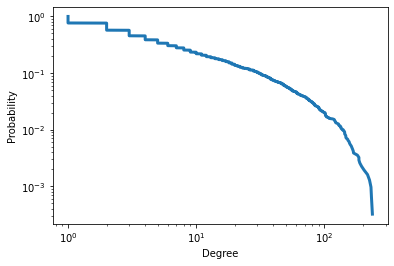

In [8]:
### Openflights
m = 36386/2
adj = (openflights.adjacency>0)
#matrix = adj.toarray()
#matrix_without_weight = (adjacency>0)
n = adj.shape[0]
degrees = adj.T.dot(np.ones(n))
Ezero = np.mean(degrees)
#cv = np.sqrt((Einf/Ezero)-1)
cv_openflight = np.std(degrees)/Ezero


plt.loglog(np.sort(degrees), 1 - np.arange(n) / n, lw = 3)
_ = plt.xlabel('Degree')
_ = plt.ylabel('Probability')

In [9]:
# Poisson
cv_openflight_poisson = np.sqrt(Ezero)/Ezero
np.sqrt(Ezero)

3.4276506751404945

Wikivitals in-degree

In [10]:
### Wikivitals in-degree
adj = wikivitals.adjacency
n = adj.shape[0]
degrees = adj.T.dot(np.ones(n))
Ezero = np.mean(degrees)
cv_wiki_in = np.std(degrees)/Ezero


In [11]:
"""
Pareto's law to graph the power's law
"""
# este es el valor de alpha k obtenemos con el uno de la esperanza y la mediana
alpha2 =1.736
V =np.std(degrees)**2
alpha=(Ezero**2+Ezero*V)/(V*(Ezero-2))
# aqui hemo usado la mediana para el calculo de km, referencia wikipedia
km=np.median(degrees)/2**(1/alpha)

x = np.array(list(set(np.sort(degrees))))
x = x[1:]
y = (km/x)**alpha2
y[x<km]=1

In [12]:
"""
Erdos-renyi
"""
p = Ezero/n
erdos_renyi = erdos_renyie(n,p)
degrees_erdos = erdos_renyi.T.dot(np.ones(n))


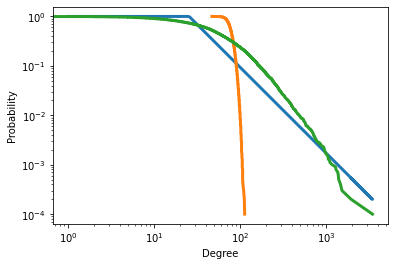

In [13]:
# Power law
plt.loglog(x,y, lw = 3)
# Erdos-renyi
plt.loglog(np.sort(degrees_erdos), 1 - np.arange(n) / n, lw = 3)
# Graph from data
plt.loglog(np.sort(degrees), 1 - np.arange(n) / n, lw = 3)
_ = plt.xlabel('Degree')
_ = plt.ylabel('Probability')

In [14]:
cv_wiki_in_poisson = np.sqrt(Ezero)/Ezero

Wikivitals out-degree

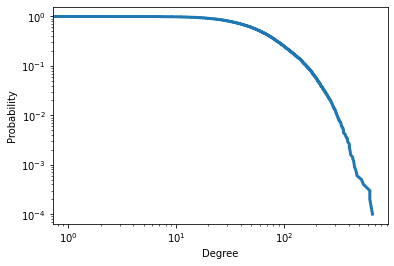

In [15]:
### Wikivitals out-degree
adj = wikivitals.adjacency
n = adj.shape[0]
degrees = adj.dot(np.ones(n))
Ezero = np.mean(degrees)
cv_wiki_out = np.std(degrees)/Ezero

plt.loglog(np.sort(degrees), 1 - np.arange(n) / n, lw = 3)
_ = plt.xlabel('Degree')
_ = plt.ylabel('Probability')

In [16]:
cv_wiki_out_poisson = np.sqrt(Ezero)/Ezero

## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Complete the following function computing the distances from any given node in number of hops.
* Compare it to the function `shortest_path` of SciPy on WikiVitals.

In [17]:
def get_distances(adjacency: sparse.csr_matrix, source: int) -> np.ndarray:
    '''Get distances from a source node in number of hops.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    source:
        Source node
    
    Returns
    -------
    distances:
        Vector of distances.
    '''
    n = adjacency.shape[0]
    distances = np.inf * np.ones(n)
    distances[source] = 0
    # vector of nodes reached after t steps
    reached = np.zeros(n).astype(bool)
    reached[source] = True
    change = True
    t = 0
    while change:
        t += 1
        reached = adjacency.T.dot(reached)
        # New nodes that are reached
        new_nodes = np.argwhere((distances == np.inf) * reached).ravel()
        distances[new_nodes] = t
        change = len(new_nodes)
    return distances

In [18]:
t = 1

print(get_distances(adjacency,t))
print(shortest_path(adjacency, indices=t))
print("Wikivitals")
print(get_distances(wikivitals.adjacency.T,t))
print(shortest_path(wikivitals.adjacency.T, indices=t))

[1. 0. 1. ... 5. 5. 5.]
[1. 0. 1. ... 5. 5. 5.]
Wikivitals
[1. 0. 1. ... 3. 2. 2.]
[1. 0. 1. ... 3. 2. 2.]


## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

## To do

In [19]:
# Charles de Gaulle
names = openflights.names
cdg = {i:name for i, name in enumerate(names) if 'Gaulle' in name}
index = list(cdg.keys())[0]

dist_cdg = get_distances(adjacency.T,index).astype(int)
#dict_distance = {i:dist_cdg.count(i) for i in dist_cdg}
distance1 = np.sum(dist_cdg==1)
distance2 = np.sum(dist_cdg==2)
distance3 = np.sum(dist_cdg==3)
numberOfDistances = len(dist_cdg)
percentage1 = distance1/numberOfDistances
percentage2 = distance2/numberOfDistances
percentage3 = distance3/numberOfDistances


In [20]:
#Wikivitals
namesWiki = wikivitals.names
paris = {i:name for i, name in enumerate(namesWiki) if 'Paris' in name}
indexParis = 3279

dist_paris = get_distances(wikivitals.adjacency.T,indexParis)
distance1 = np.sum(dist_paris==1)
distance2 = np.sum(dist_paris==2)
distance3 = np.sum(dist_paris==3)
numberOfDistances = len(dist_paris)
percentage1 = distance1/numberOfDistances
percentage2 = distance2/numberOfDistances
percentage3 = distance3/numberOfDistances

The following function estimates the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph.

* Adapt this function so that it returns a path of length equal to this estimated diameter.
* Give a path of **length at least 10** in Openflights (with the names of the airports).
* Give a path of **length at least 5** in WikiVitals (with the names of the articles).

In [21]:
def estimate_diameter(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Estimate the diameter of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    diameter:
        Estimation of the diameter.
        This function takes a random number of nodes,
        then they find the farthest nodes, these can be seen
        as the borders, then we compute the the farthest node that
        finally are the estimate.
    '''    
    n = adjacency.shape[0]
    nodes = np.random.choice(n, size=n_samples)
    distances = shortest_path(adjacency.T, indices=nodes)
    #print(distances)
    sources = np.where(np.isinf(distances), -1, distances).argmax(axis=1)
    #print(sources)
    test = np.where(np.isinf(distances), -1, distances).max(axis=1)
    #print(test)
    distances = shortest_path(adjacency, indices=sources)
    diameter = np.where(np.isinf(distances), -1, distances).max()
    return int(diameter)

In [22]:
estimate_diameter(adjacency)

12

In [23]:
n_samples=100
nodes = np.random.choice(n, size=n_samples)
print(nodes)

[4918 1738 5469 7044 7537 3118 1342 2443 3256 6058 4284  854  289 9416
 3346 2603 7272 2566 3617 8745   26 1412 3692 9630 6295  464 9213 1208
  622 1803  130 8613 3300 8721 8671 4603 3771 3206 1628 3026 7854  714
 2160 3762 3411 6904 2637 5034 3797 7233 9751 1271 6360 8153  473 7065
 4924 6890 6998 9367 4734  404 1640 9418 4530  942 5182 8229 2176 6947
 3013 4862 6042 6708 1910 8236 5777 1030 1735 5294 5917 1785 8931 9508
 6755 4816 8213 4042 8439 4458 4573 9562 6624 7429 3340 2337 9604 1064
 3979   49]


In [24]:
def estimate_path(adjacency: sparse.csr_matrix, n_samples=100) -> list:
    '''Return a path of length equal to the estimated diameter of a graph.

    Parameters
    ----------
    adjacency:
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.

    Returns
    -------
    path:
        List of nodes.
    '''
    n = adjacency.shape[0]
    nodes = np.random.choice(n, size=n_samples)
    distances = shortest_path(adjacency.T, indices=nodes)
    sources = np.where(np.isinf(distances), -1, distances).argmax(axis=1)
    distances, preds = shortest_path(adjacency, indices=sources, return_predecessors=True)
    # best source
    k = np.where(np.isinf(distances), -1, distances).max(axis=1).argmax()
    source = sources[k]
    pred = preds[k]
    distance = distances[k]
    # furthest node from best source
    dest = np.where(np.isinf(distance), -1, distance).argmax()
    # backward path from dest to source
    path = []
    while dest != source:
        path.append(dest)
        dest = pred[dest]
    return list(np.flip(path))


In [25]:
adjacency = wikivitals.adjacency
path_wikivitals = estimate_path(adjacency)
print(path_wikivitals)
print(len(path_wikivitals))

[1169, 7931, 2704, 8607, 5151, 261]
6


In [26]:
adjacency2 = openflights.adjacency
path_openflights = estimate_path(adjacency2)
print(path_openflights)
print(len(path_openflights))

[2224, 6, 8, 293, 999, 1587, 1590, 2707, 2711, 2656]
10


In [27]:
names = wikivitals.names

## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors.
* Plot the corresponding histogram.

**Hint:** Use distances in the bipartite graph. Do **not** try to compute the co-starring graph of actors, with adjacency matrix $A = B^TB$ where $B$ is the movie-actor biadjacency matrix (guess why).

In [28]:
biadjacency = cinema.biadjacency
adjacency = biadjacency.T.dot(biadjacency)

names = cinema.names_col
bacon = {i:name for i, name in enumerate(names) if 'Bacon' in name}
print(bacon)
indexBacon = 3465

cotillon = {i:name for i, name in enumerate(names) if 'Cotillard' in name}
print(cotillon)
indexCotillon = 3814

distance = get_distances((adjacency), indexBacon)
print("Distance to Cotillard: ")
print(distance[indexCotillon])


maxDist = np.max(distance)
print(distance)
print(maxDist)



{2994: 'Frank Bacon', 3465: 'Kevin Bacon', 4052: 'Lloyd Bacon', 10011: 'Irving Bacon', 18496: 'Max Bacon', 39070: 'David Bacon'}
{3814: 'Marion Cotillard'}
Distance to Cotillard: 
2.0
[3. 3. 2. ... 3. 3. 7.]
13.0


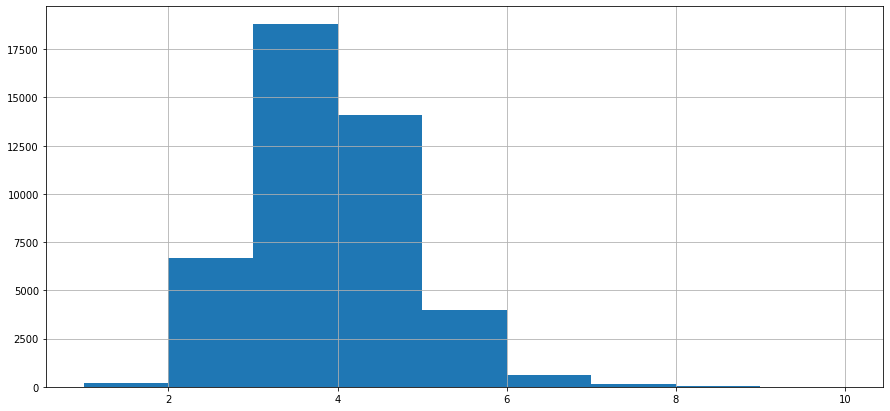

In [29]:
"""
"""
plt.figure(figsize=(15,7))
plt.hist(distance,np.arange(1,11))
plt.grid()
plt.show()

Text(0, 0.5, 'Probability')

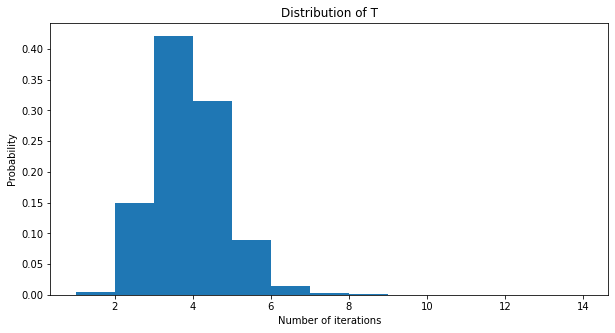

In [30]:
plt.figure(figsize=(10,5))
b = np.linspace(1,max(distance.astype(int))+1,max(distance.astype(int))+1)
h = plt.hist(distance,bins = b, density = True)
plt.title("Distribution of T")
plt.xlabel("Number of iterations")
plt.ylabel("Probability")



In [31]:
print(adjacency.toarray())


[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]


## 3. Clustering coefficient

You will now learn to estimate the clustering coefficient of a graph.

## To do


* Complete the following function to estimate the clustering coefficient of a graph.
* Test it on a triangle and  a line.
* Compute the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph).

**Hint:** A triangle is... a cycle of length 3

In [32]:
def clustering_coefficient(adjacency: sparse.csr_matrix, n_samples: int = 500) -> float:
    '''Get the clustering coefficient of a graph.

    Parameters
    ----------
    adjacency:
        Adjacency matrix of the graph.

    Returns
    -------
    clustering_coef:
        Clustering coefficient.
    '''


    n = adjacency.shape[0]
    if n_samples < n:
        nodes = np.random.choice(n, size=n_samples, replace=False)
    else:
        nodes = np.arange(n)

    D = adjacency.dot(np.ones(n))
    # Doc : https://www.geeksforgeeks.org/number-of-triangles-in-a-undirected-graph/
    temp = np.linalg.matrix_power(adjacency.toarray(),3)
    triangles = np.trace( temp ) / 6

    # to be modified
    # a single loop on preselected nodes allowed

    clustering_coef = (6*triangles)/(np.dot(D,D-1))

    return clustering_coef


In [33]:
triangle = cyclic_graph(3)
coef = clustering_coefficient(triangle)
print(coef)

1.0


In [34]:
line = linear_graph(5)

In [35]:
import networkx as nx
G = nx.from_scipy_sparse_matrix(openflights.adjacency)
cc=nx.average_clustering(G)
print(cc)

0.47104596951619976


In [36]:
from sknetwork.data import karate_club
adjacency = karate_club()
G = nx.from_scipy_sparse_matrix(adjacency)
cc=nx.average_clustering(G)
print(cc)



0.5706384782076823


In [37]:
from sknetwork.data import karate_club
adjacency = karate_club()
cc = clustering_coefficient(adjacency)
print(cc)

0.030303030303030304
